In [68]:
import torch
import src.datasets as my_datasets
from src.dataset_bundle import *
import pandas as pd
from wilds.common.data_loaders import get_eval_loader
from src.server import *
import matplotlib.pyplot as plt
import numpy as np
import argparse
from wilds import get_dataset

In [2]:
config_file = './config/ERM/pacs_c10/fl_0_v1_acps.json'
with open(config_file) as fh:
    config = json.load(fh)
hparam = config

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Current available device: {device}')
seed = hparam['global']['seed']
set_seed(seed)
config['id'] = 'abc'

Current available device: cuda:0


In [4]:
if hparam['global']['dataset'].lower() == 'pacs':
    dataset = my_datasets.PACS(version='1.0', root_dir=hparam['dataset']['dataset_path'], download=True, split_scheme=hparam['global']['split_scheme'])
elif hparam['global']['dataset'].lower() == 'officehome':
    dataset = my_datasets.OfficeHome(version='1.0', root_dir=hparam['dataset']['dataset_path'], download=True, split_scheme=hparam["split_scheme"])
elif hparam['global']['dataset'].lower() == 'femnist':
    dataset = my_datasets.FEMNIST(version='1.0', root_dir=hparam['dataset']['dataset_path'], download=True)
elif hparam['global']['dataset'].lower() == 'celeba':
    dataset = get_dataset(dataset="celebA", root_dir=hparam['dataset']['dataset_path'], download=True)
else:
    dataset = get_dataset(dataset=hparam['global']["dataset"].lower(), root_dir=hparam['dataset']['dataset_path'], download=True)

acc


In [5]:
if hparam['client']['algorithm'] == "FedSR":
    ds_bundle = eval(hparam['global']["dataset"])(dataset, hparam['global']["feature_dimension"], probabilistic=True)
elif hparam['client']['algorithm'] == "ProposalClient":
    ds_bundle = eval(f"{hparam['global']['dataset']}Proposal")(dataset, hparam['global']["feature_dimension"], hparam, probabilistic=False)
else:
    if hparam['global']['dataset'].lower() == 'py150' or hparam['global']['dataset'].lower() == 'civilcomments':
        ds_bundle = eval(hparam['global']["dataset"])(dataset, probabilistic=False)
    else:
        ds_bundle = eval(hparam['global']["dataset"])(dataset, hparam['global']["feature_dimension"], probabilistic=False)

/mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
if hparam['client']['algorithm'] == "FedDG":
    if hparam['global']["dataset"].lower() == "iwildcam":
        dataset = my_datasets.FourierIwildCam(root_dir=hparam, download=True)
        total_subset = dataset.get_subset('train', transform=ds_bundle.test_transform)
    elif hparam['global']["dataset"].lower() == "pacs":
        dataset = my_datasets.FourierPACS(root_dir=hparam, download=True, split_scheme=hparam['global']["split_scheme"])
        total_subset = dataset.get_subset('train', transform=ds_bundle.test_transform)
    else:
        raise NotImplementedError
else:
    total_subset = dataset.get_subset('train', transform=ds_bundle.train_transform)

In [7]:
testloader = {}
for split in dataset.split_names:
    if split != 'train':
        ds = dataset.get_subset(split, transform=ds_bundle.test_transform)
        dl = get_eval_loader(loader='standard', dataset=ds, batch_size=hparam['global']["batch_size"], pin_memory=True, num_workers=4)
        testloader[split] = dl

In [10]:
central_server = eval(hparam['server']["algorithm"])(seed, config['id'], device, ds_bundle, hparam['server'])

In [18]:
central_server.register_testloader(testloader)

In [22]:
model_path = 'data/models/iid=0.1-split=ac-p-s-nclient=10-nround=50-seed=42/pacs_bestmodel_round22.pth'
central_server.setup_model(model_path, start_epoch=0)

/mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


In [90]:
def evaluate_global_model(server, dataloader):
    server.model.eval()
    server.model.to(server.device)
    with torch.no_grad():
        y_pred = None
        y_true = None
        stored_data = {
            'data': [],
            'label': [],
            'pred': [],
        }
        for idx, batch in enumerate(dataloader):
            if idx > 10 and idx < 15:
                data, labels, meta_batch = batch[0], batch[1], batch[2]
                if isinstance(meta_batch, list):
                    meta_batch = meta_batch[0]
                data, labels = data.to(server.device), labels.to(server.device)
                if server._featurizer.probabilistic:
                    features_params = server.featurizer(data)
                    z_dim = int(features_params.shape[-1]/2)
                    if len(features_params.shape) == 2:
                        z_mu = features_params[:,:z_dim]
                        z_sigma = F.softplus(features_params[:,z_dim:])
                        z_dist = dist.Independent(dist.normal.Normal(z_mu,z_sigma),1)
                    elif len(features_params.shape) == 3:
                        flattened_features_params = features_params.view(-1, features_params.shape[-1])
                        z_mu = flattened_features_params[:,:z_dim]
                        z_sigma = F.softplus(flattened_features_params[:,z_dim:])
                        z_dist = dist.Independent(dist.normal.Normal(z_mu,z_sigma),1)
                    features = z_dist.rsample()
                    if len(features_params.shape) == 3:
                        features = features.view(data.shape[0], -1, z_dim)
                else:
                    features = server.featurizer(data)
                    stored_data['data'].append(features.detach().cpu().numpy())
                    stored_data['label'].append(labels.detach().cpu().numpy())
                prediction = server.classifier(features)
                stored_data['pred'].append(prediction.detach().cpu().numpy())
                if server.ds_bundle.is_classification:
                    prediction = torch.argmax(prediction, dim=-1)
                if y_pred is None:
                    y_pred = prediction
                    y_true = labels
                    metadata = meta_batch
                else:
                    y_pred = torch.cat((y_pred, prediction))
                    y_true = torch.cat((y_true, labels))
                    metadata = torch.cat((metadata, meta_batch))
                            
        metric = server.ds_bundle.dataset.eval(y_pred.to("cpu"), y_true.to("cpu"), metadata.to("cpu"))
    return metric, stored_data

In [91]:
for name, dataloader in central_server.test_dataloader.items():
    if name == 'test':
        metrics, stored_data = evaluate_global_model(central_server, dataloader)
        print(name, metrics)

test ({'acc_avg': 0.390625}, 'Average acc: 0.391\n')


In [92]:
features = np.vstack(stored_data['data'])
labels = np.hstack(stored_data['label'])
preds = np.vstack(stored_data['pred'])

In [93]:
features.shape

(128, 512)

In [94]:
from sklearn.manifold import TSNE

In [95]:
tsne = TSNE(n_components=2, random_state=seed)
feat_tsne = tsne.fit_transform(features)

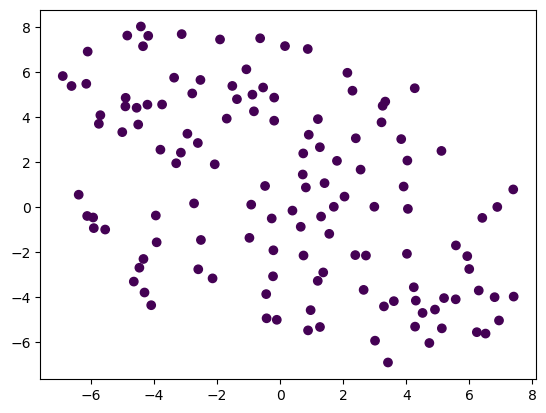

In [96]:
plt.scatter(feat_tsne[:, 0], feat_tsne[:, 1], c=labels)
plt.show();

In [87]:
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
    return exp_x / exp_x.sum(axis=1, keepdims=True)

In [97]:
soft_preds = softmax(preds)

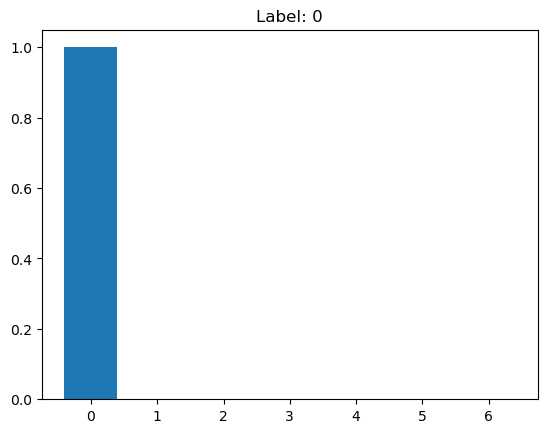

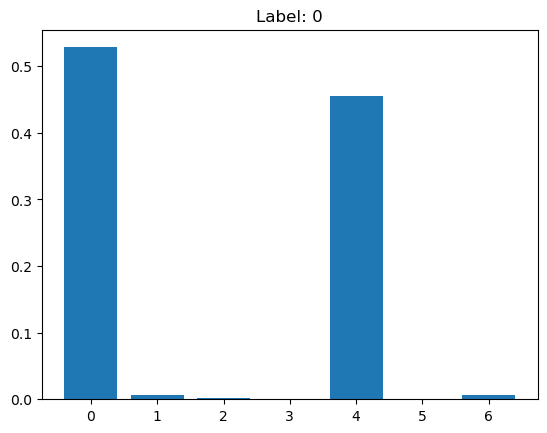

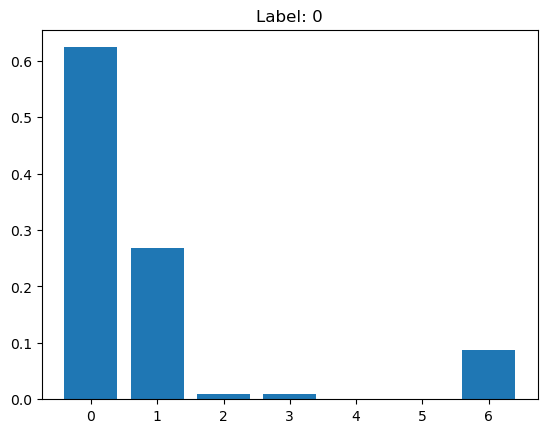

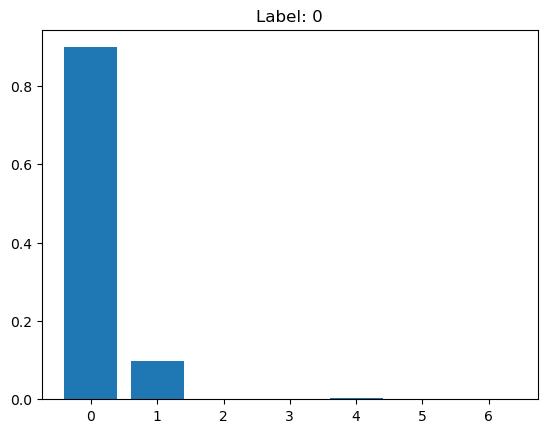

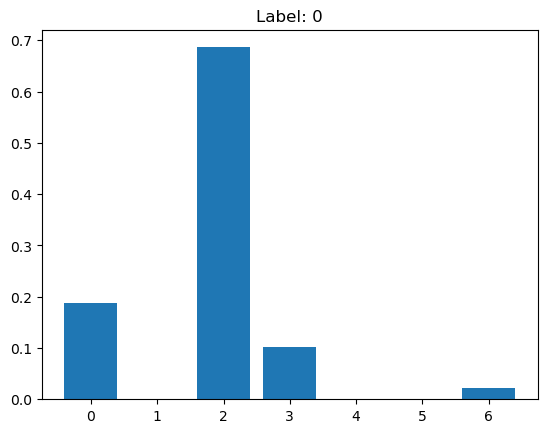

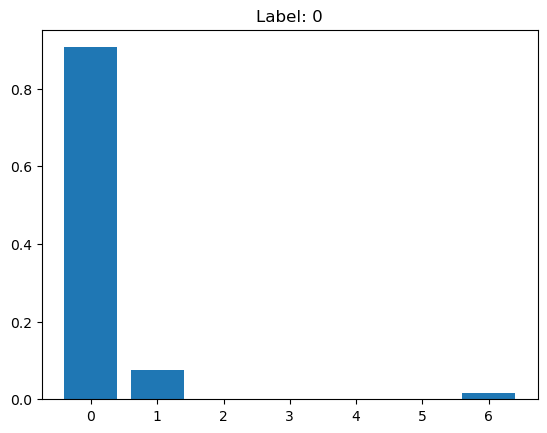

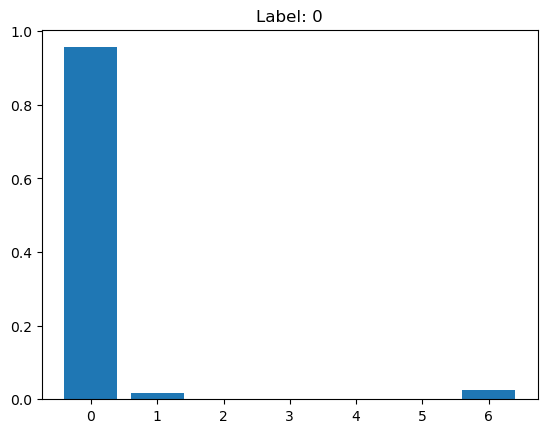

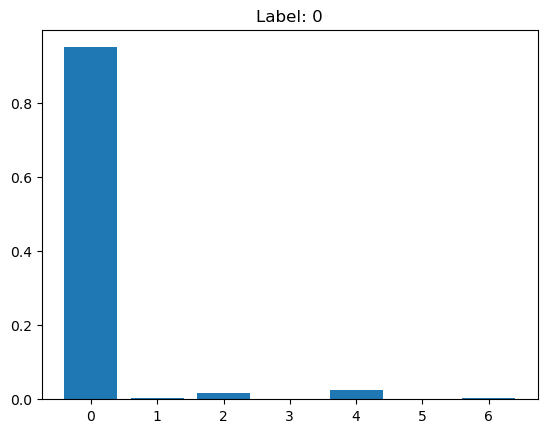

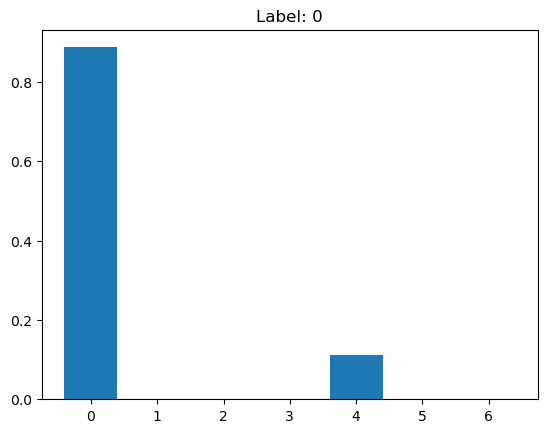

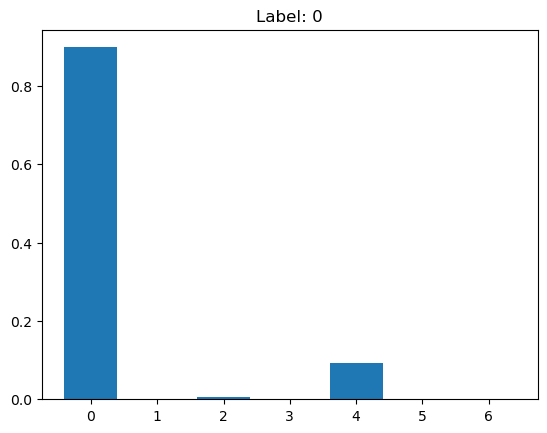

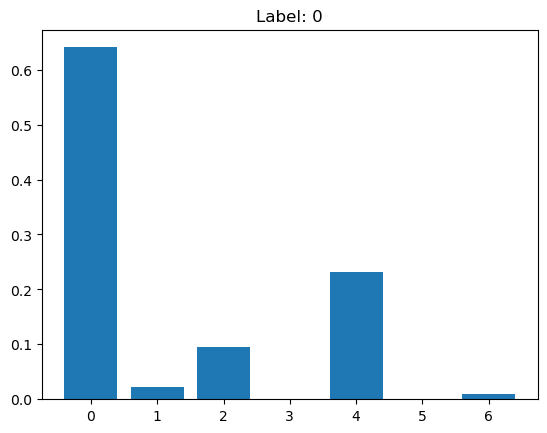

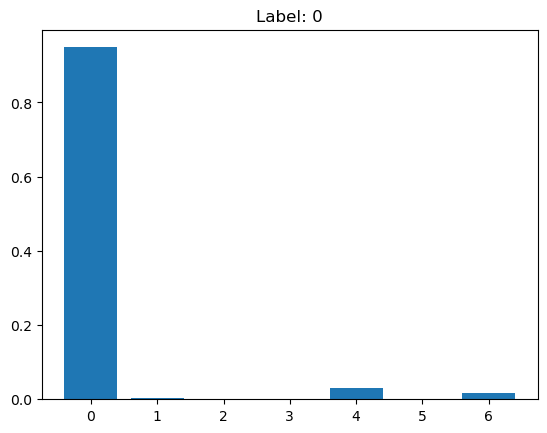

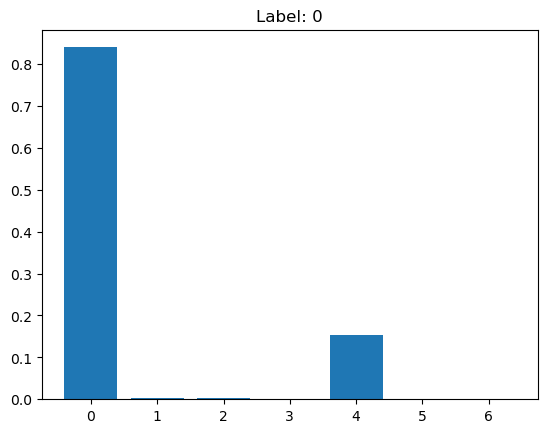

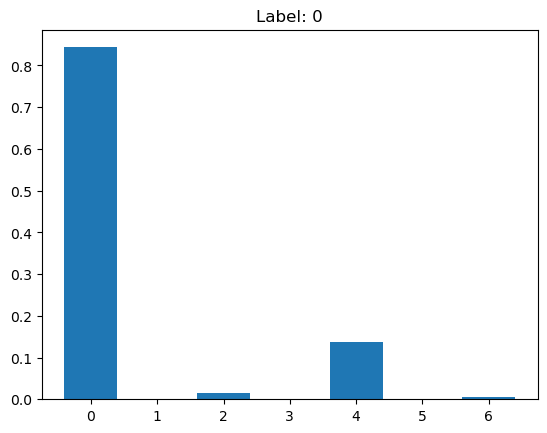

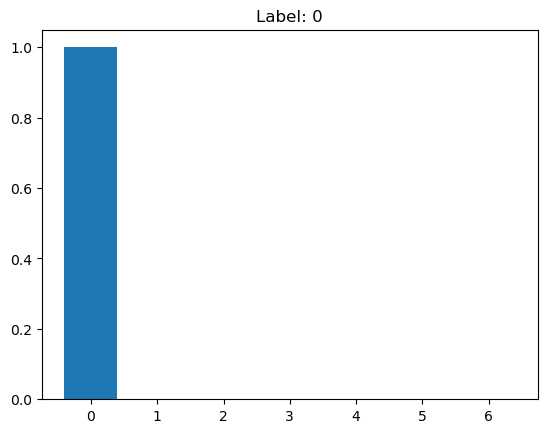

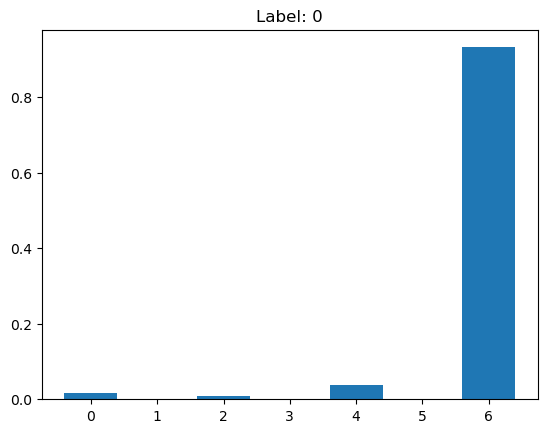

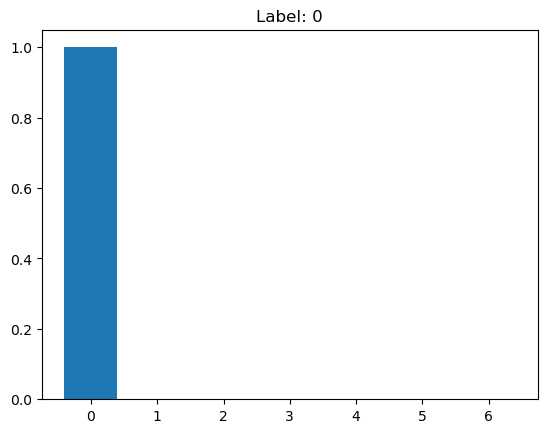

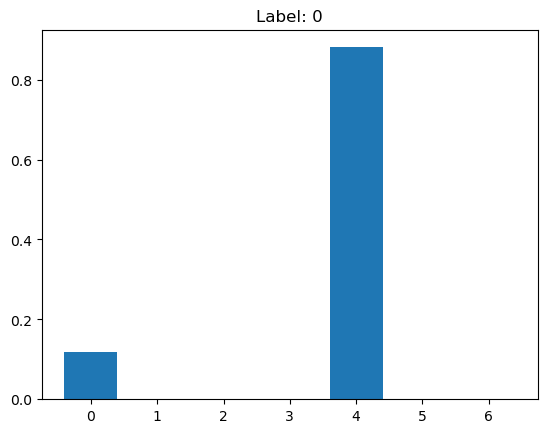

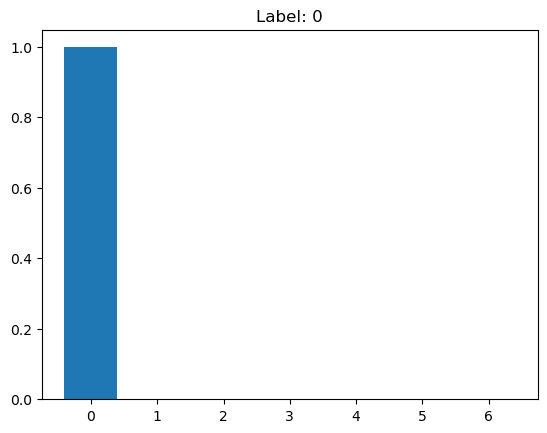

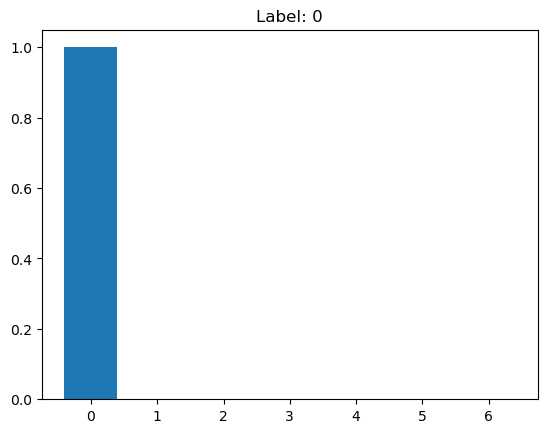

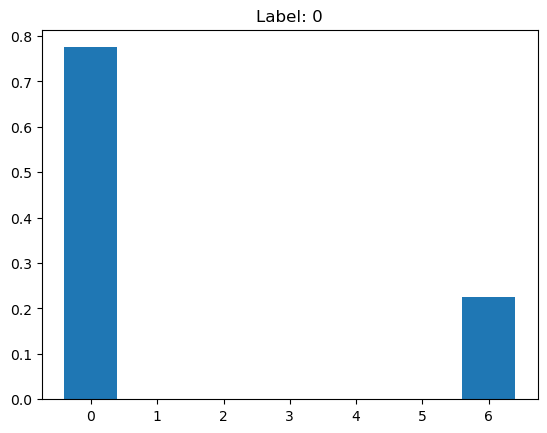

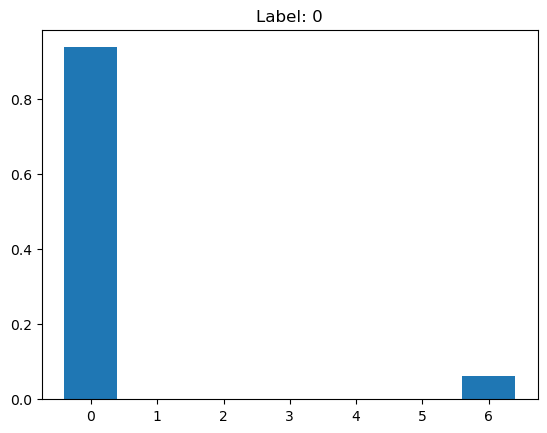

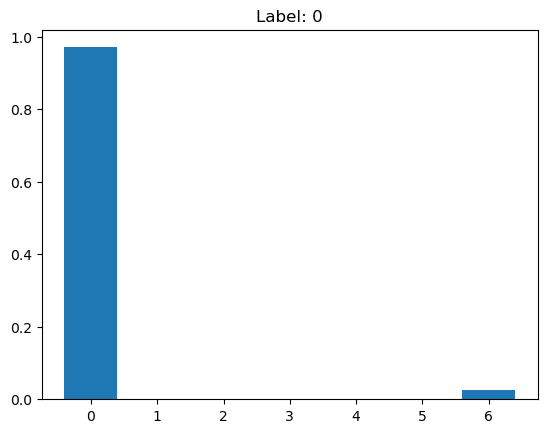

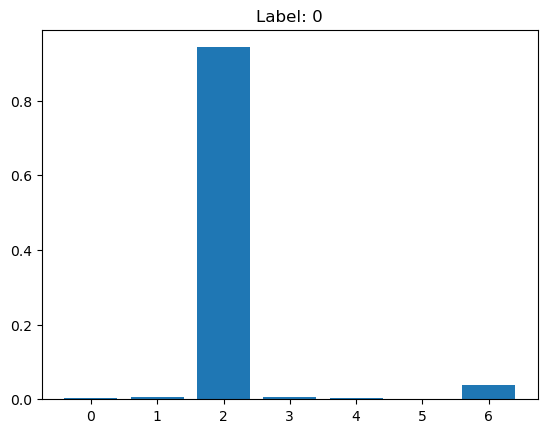

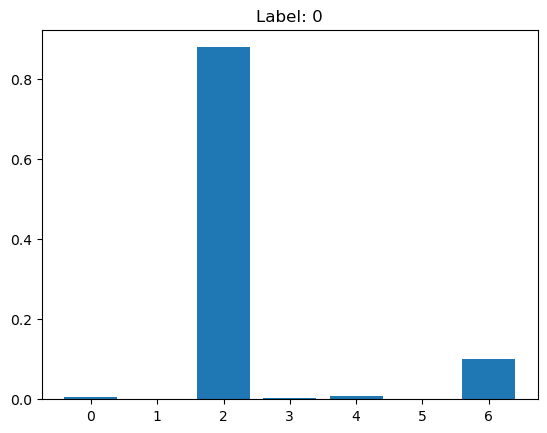

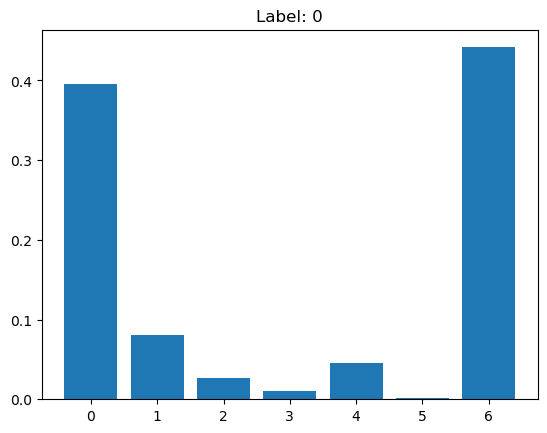

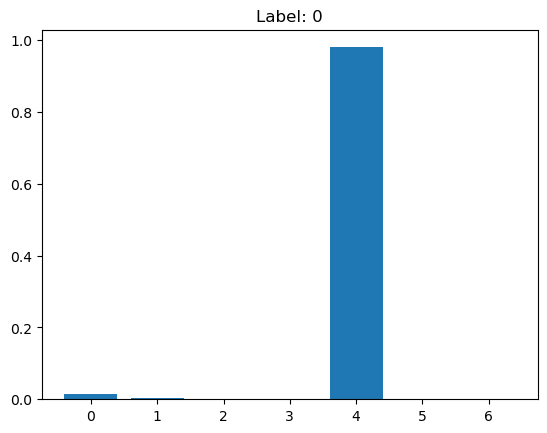

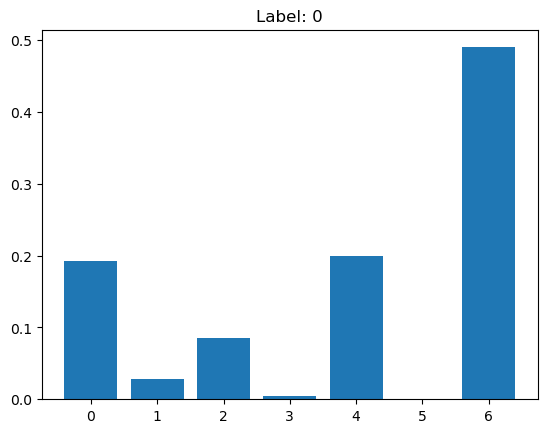

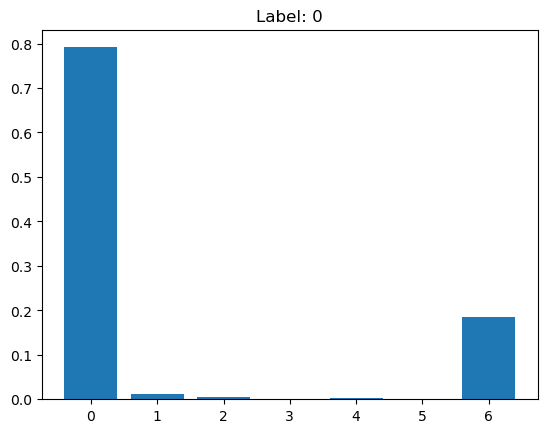

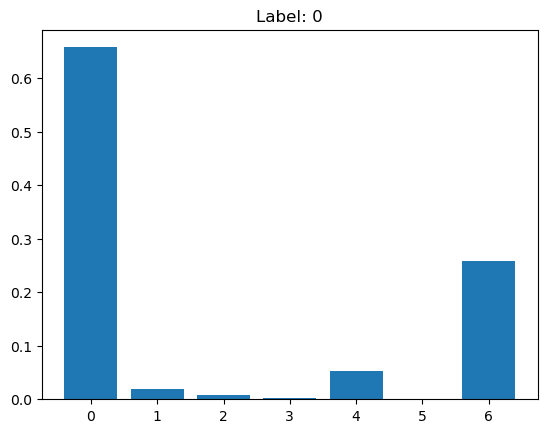

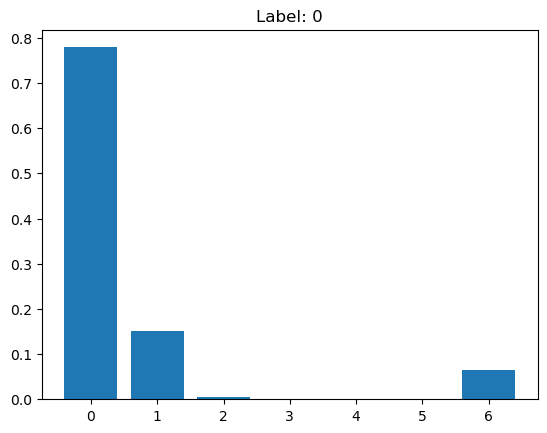

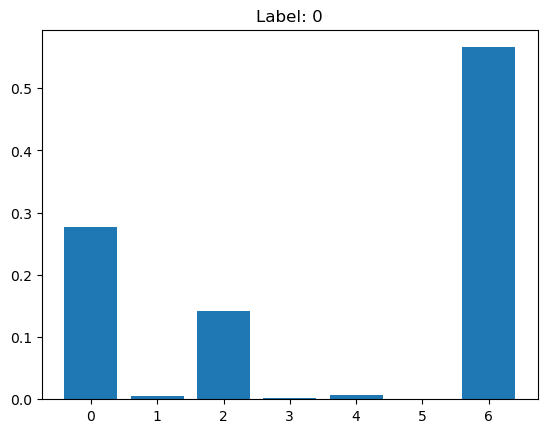

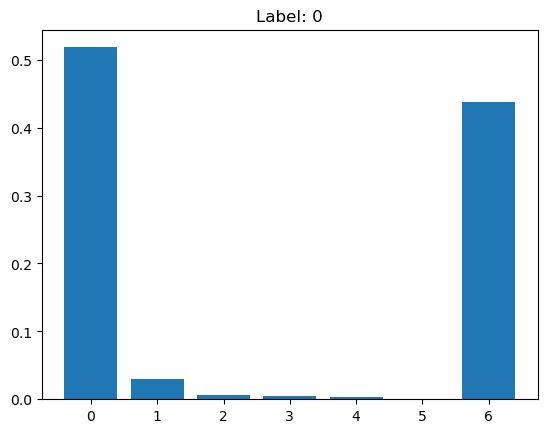

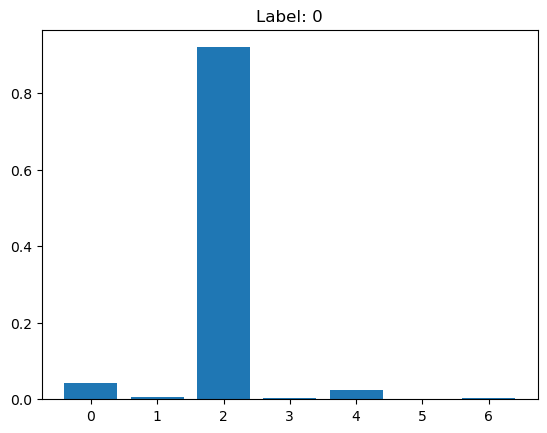

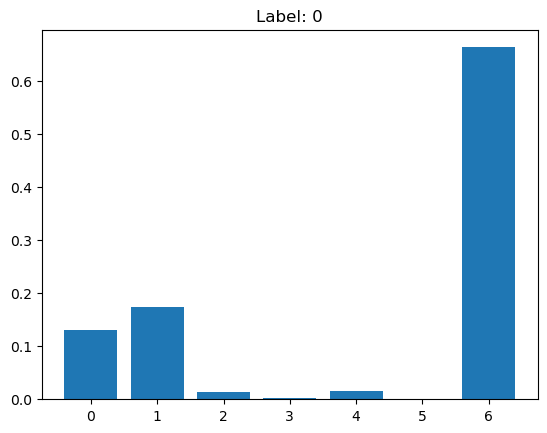

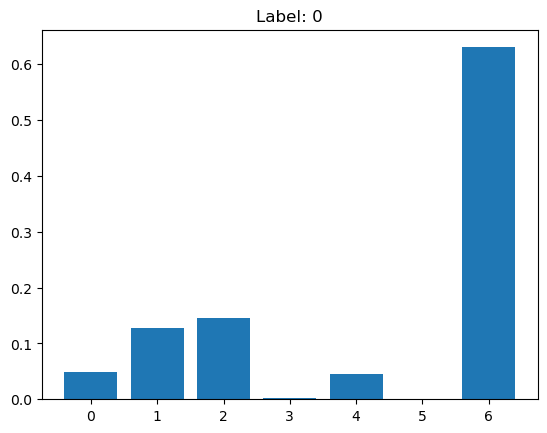

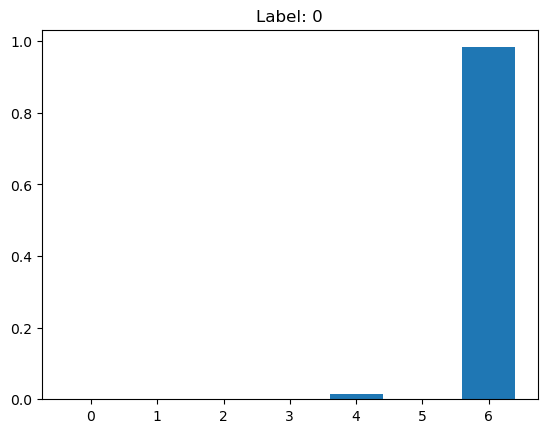

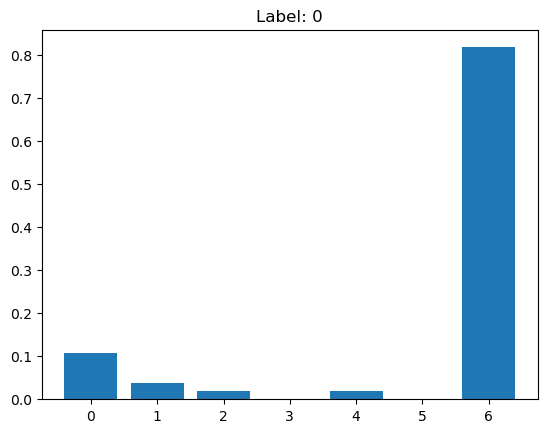

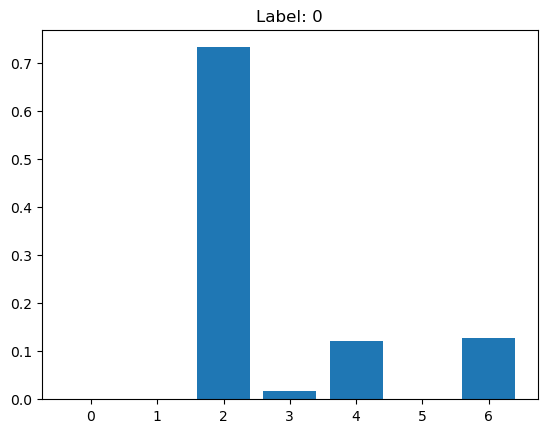

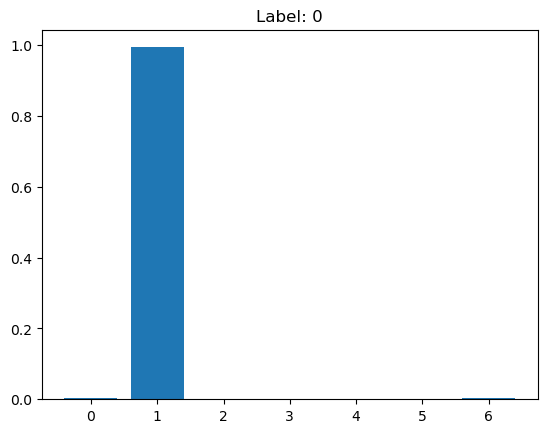

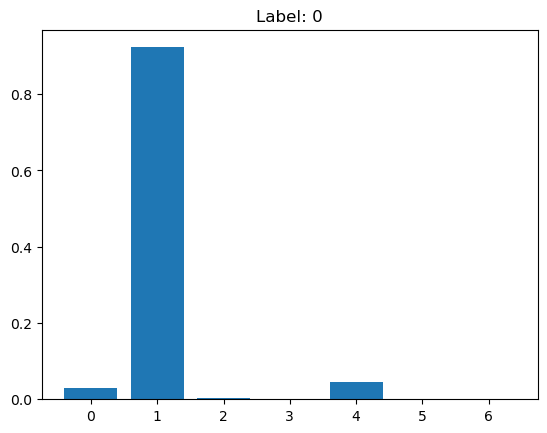

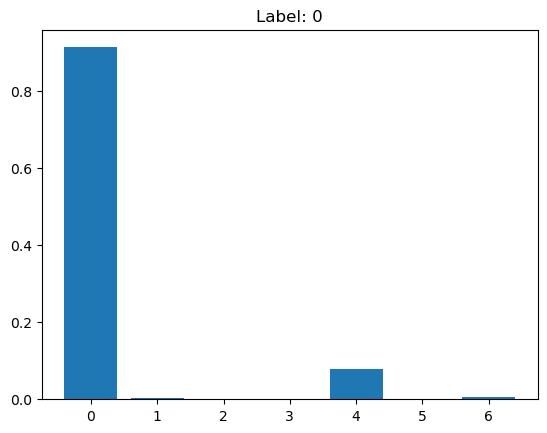

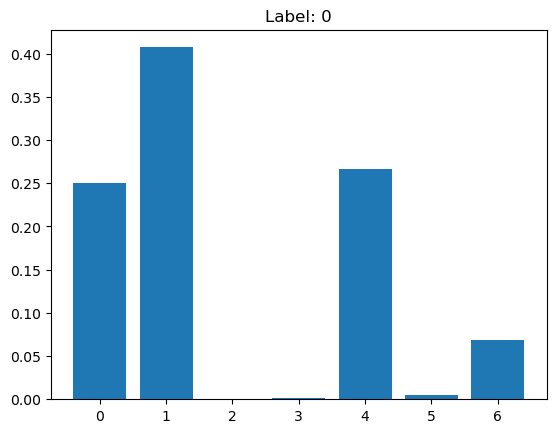

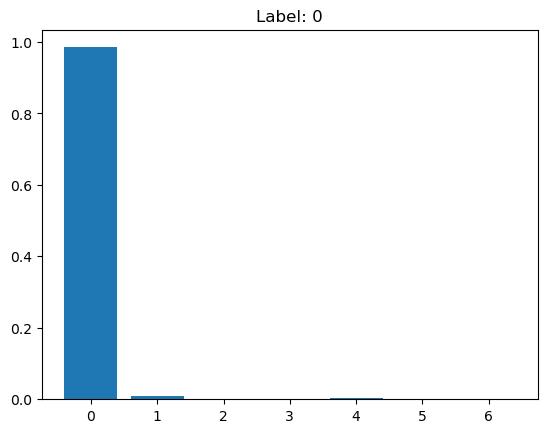

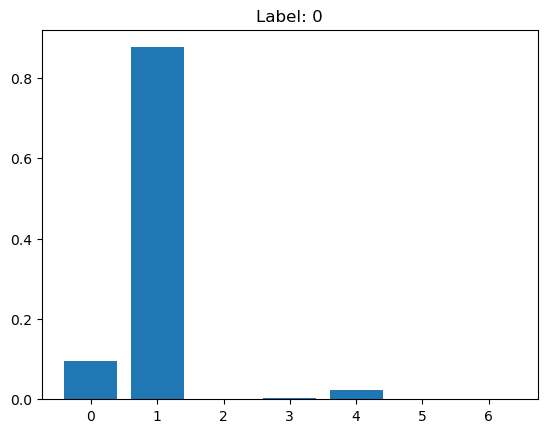

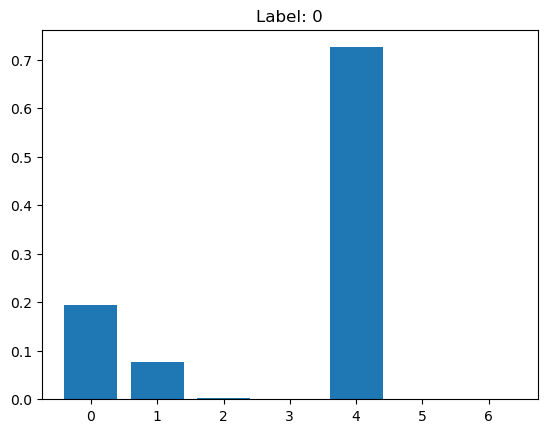

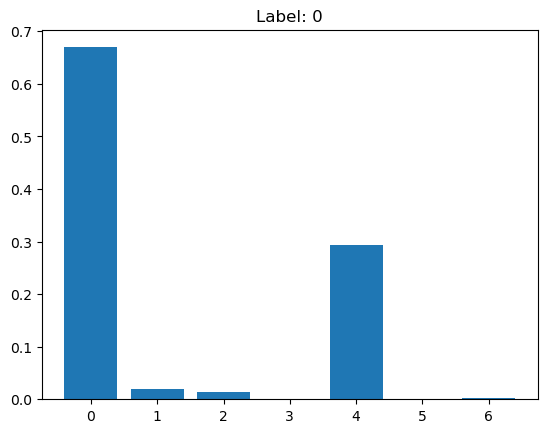

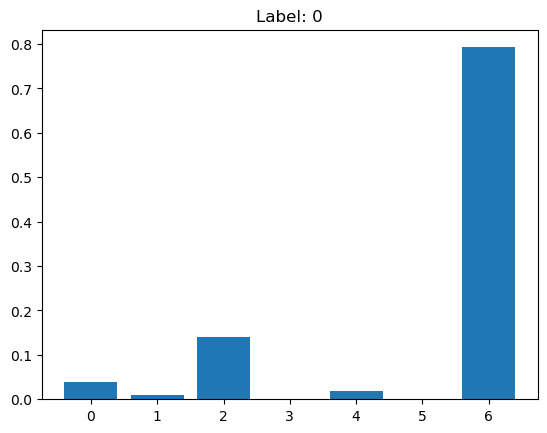

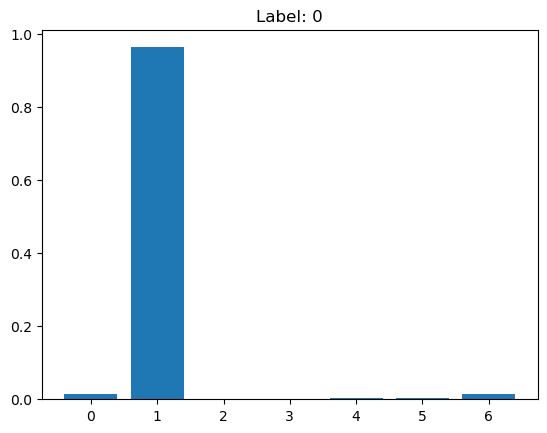

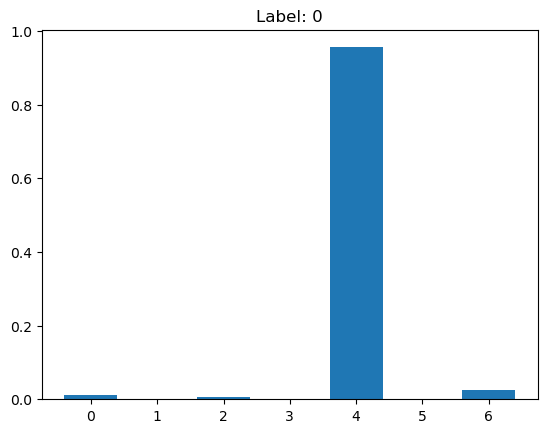

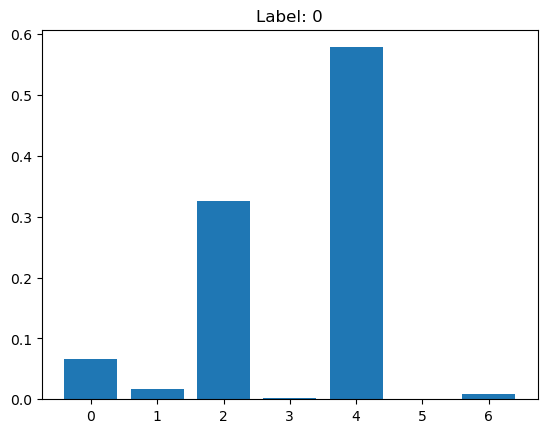

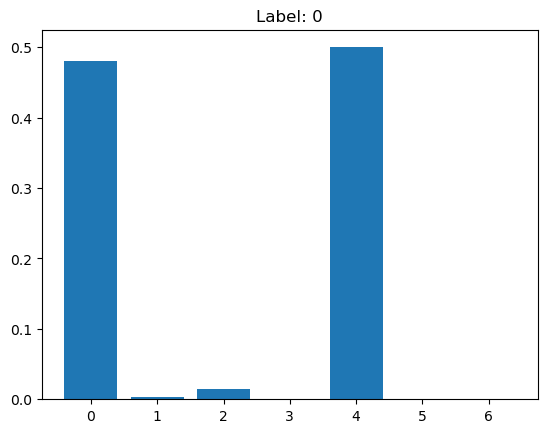

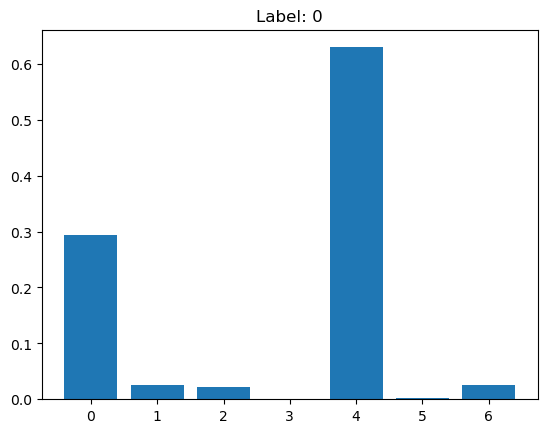

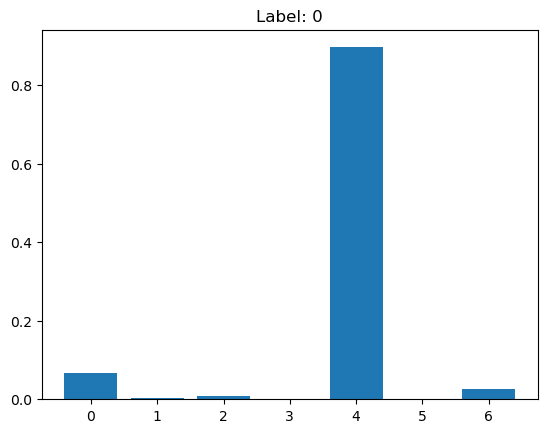

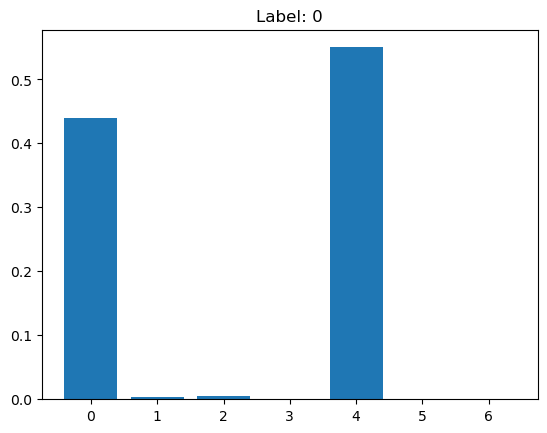

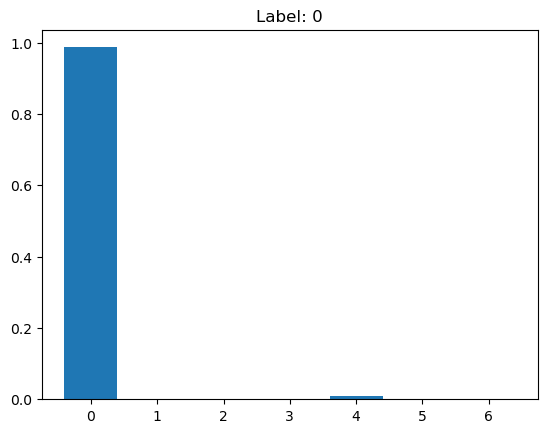

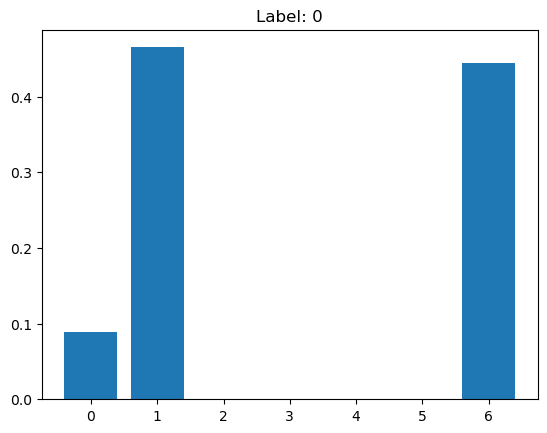

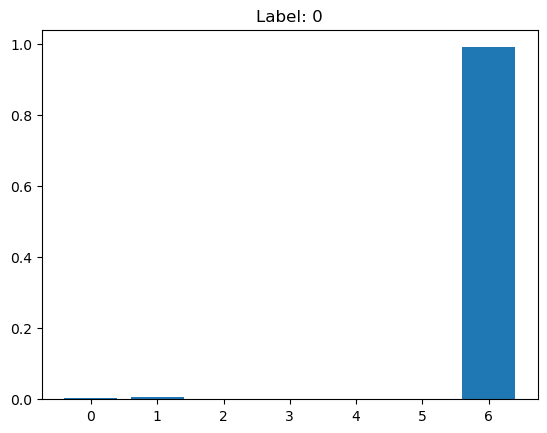

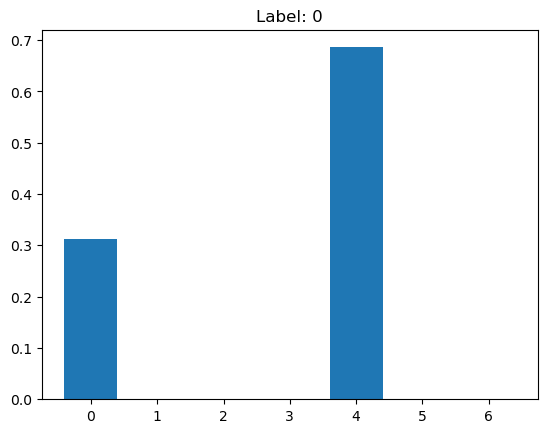

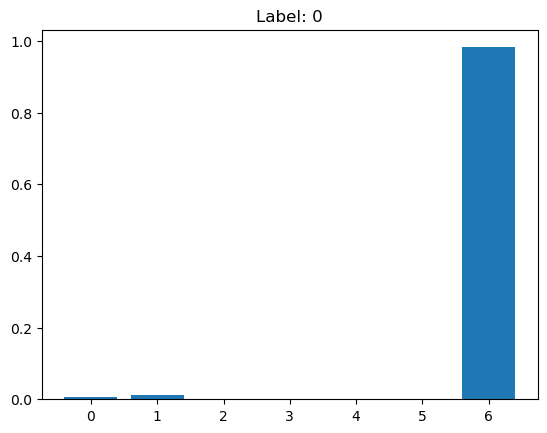

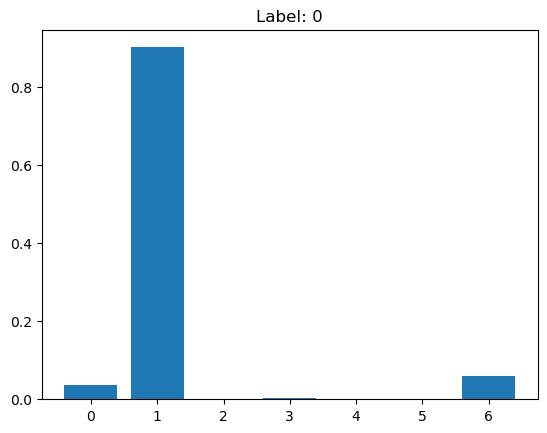

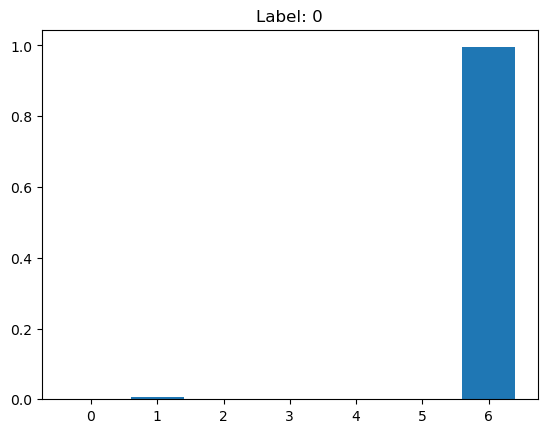

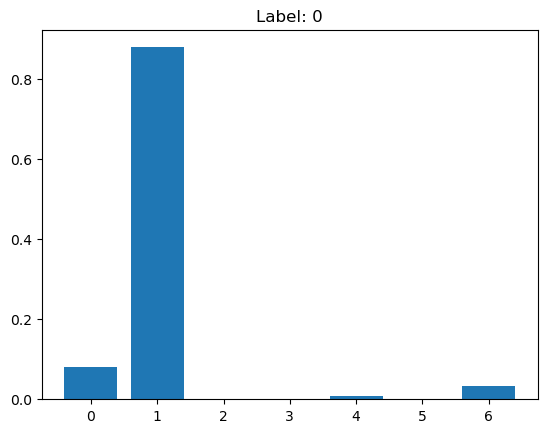

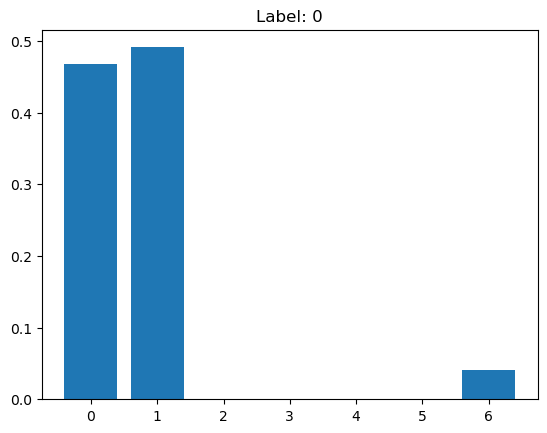

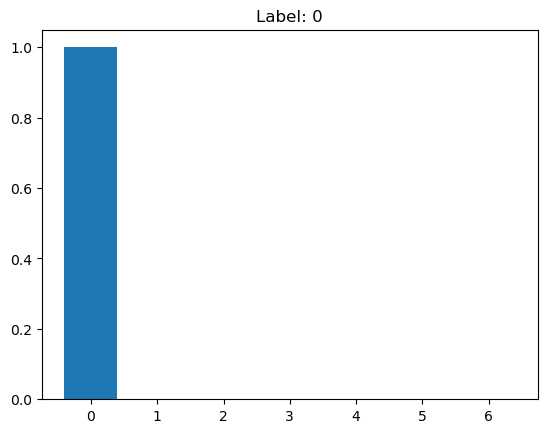

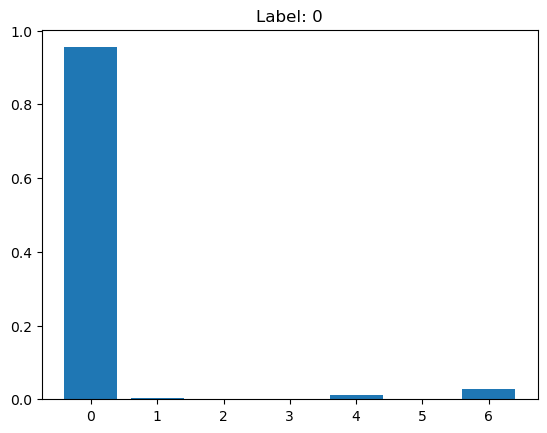

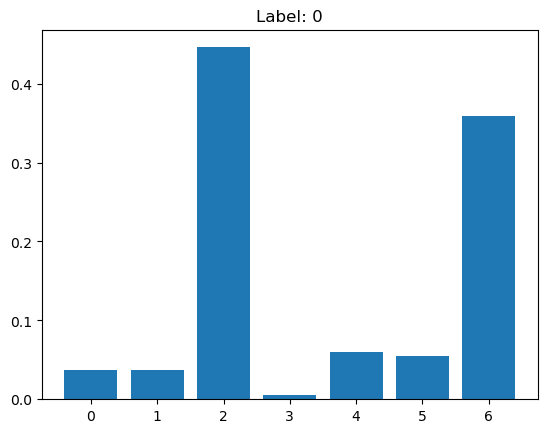

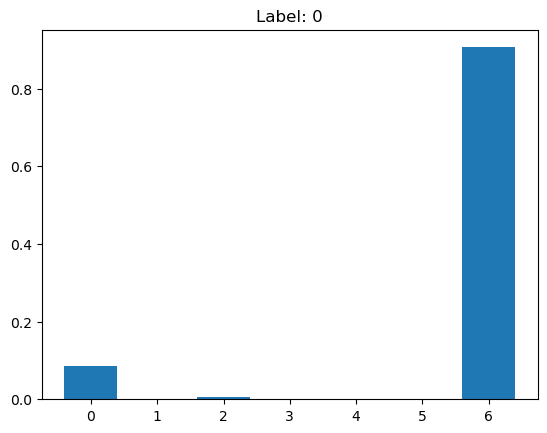

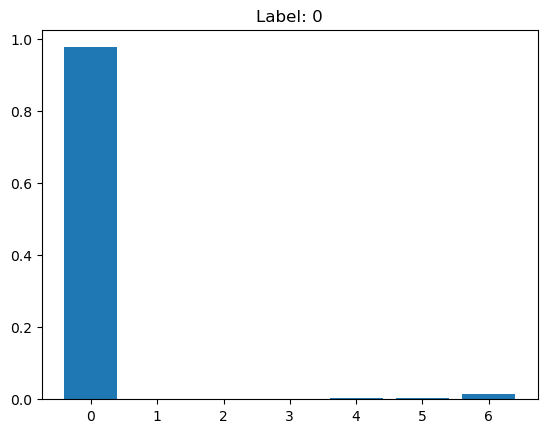

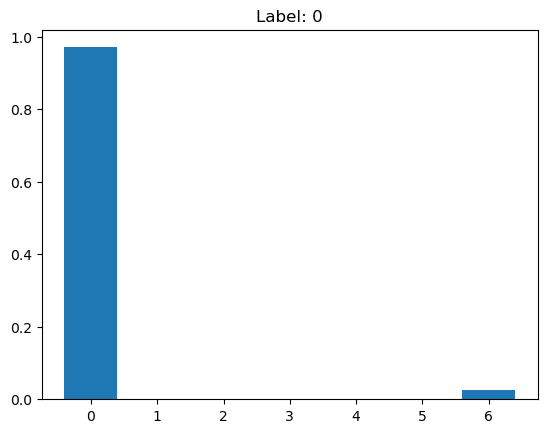

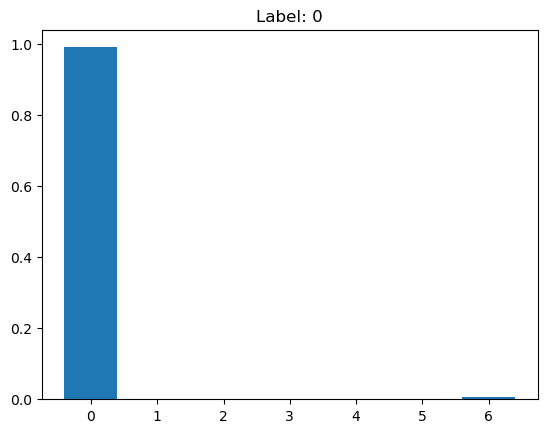

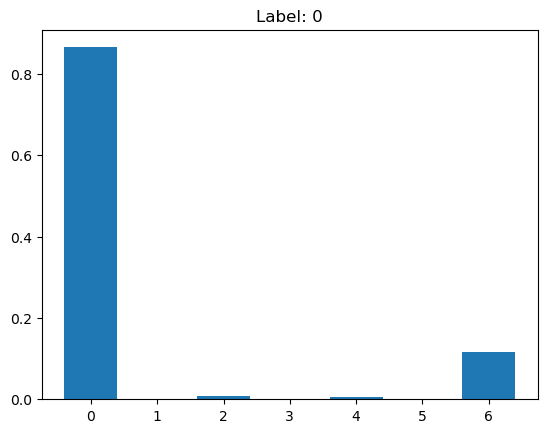

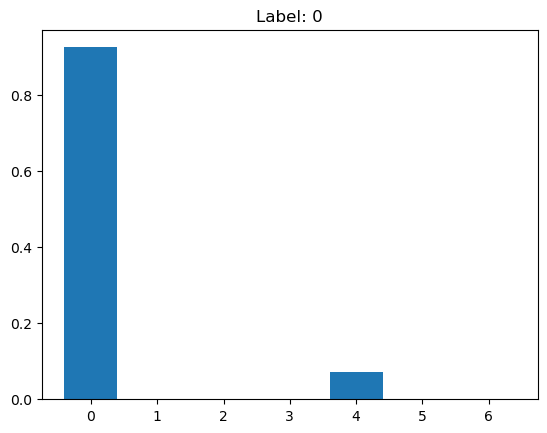

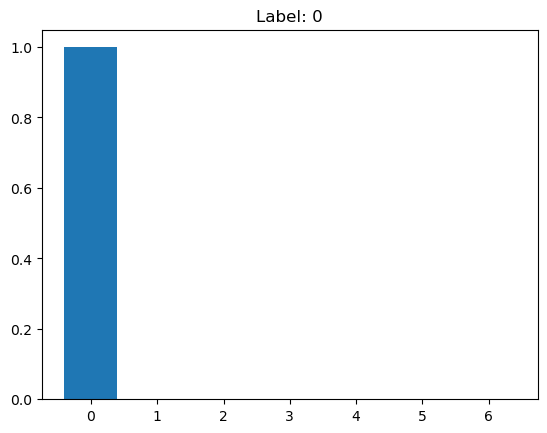

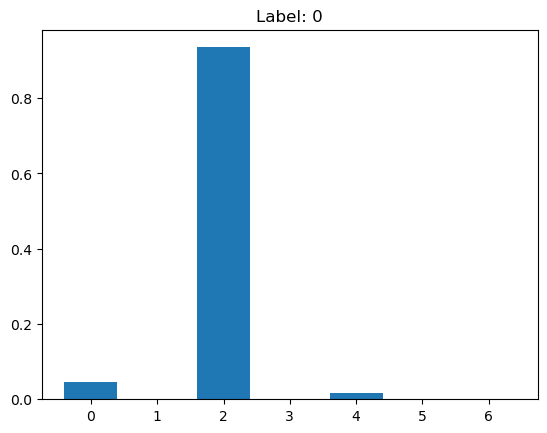

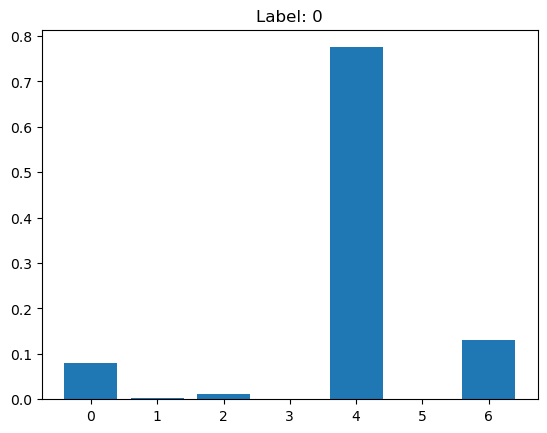

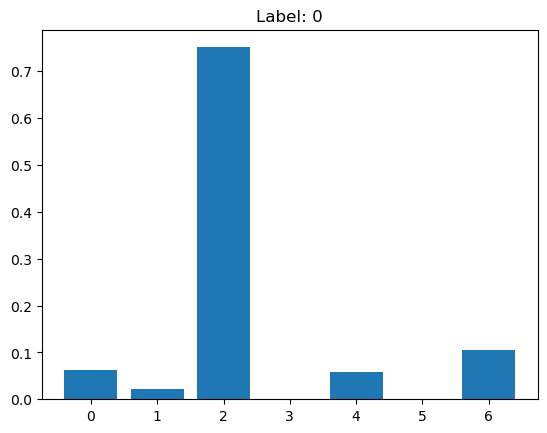

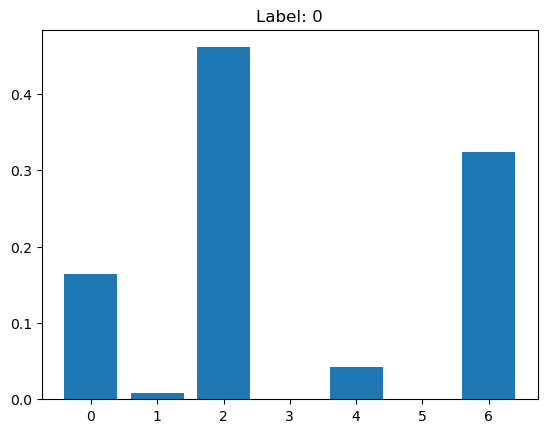

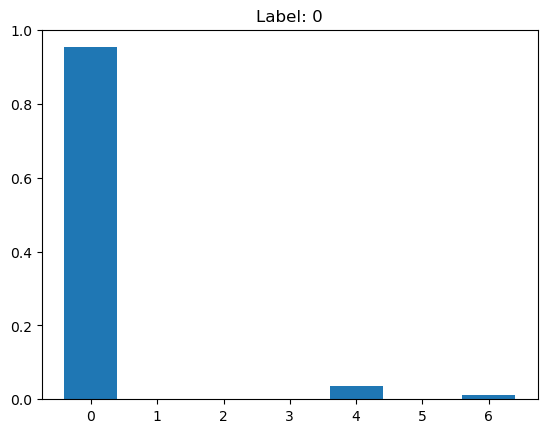

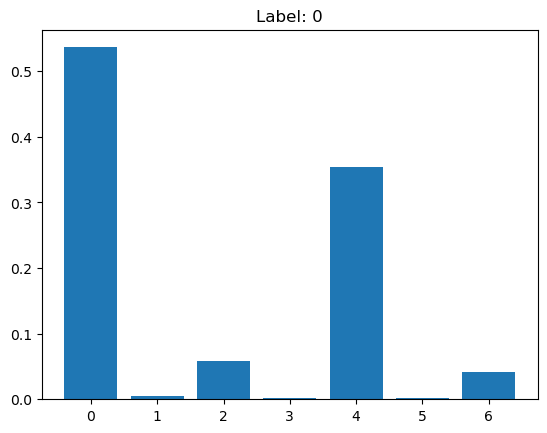

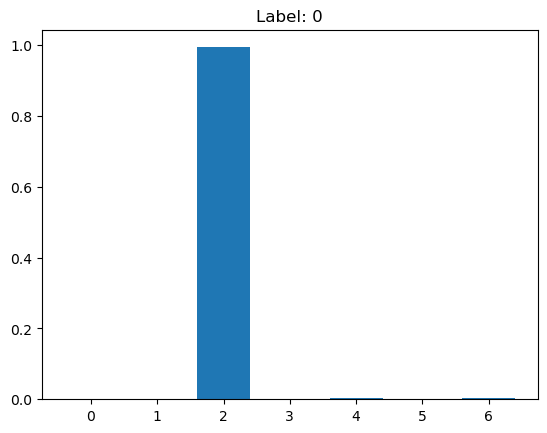

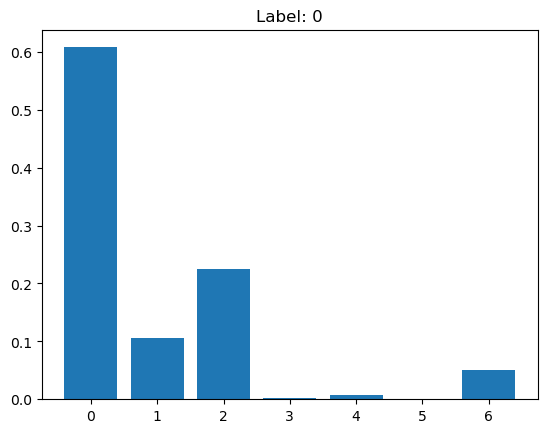

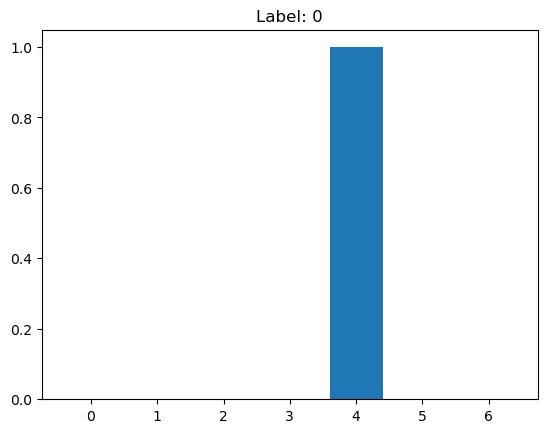

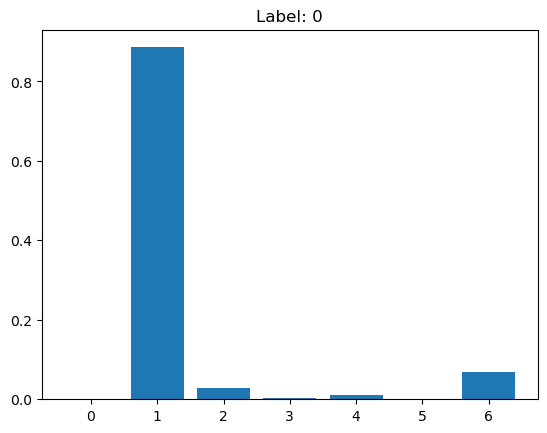

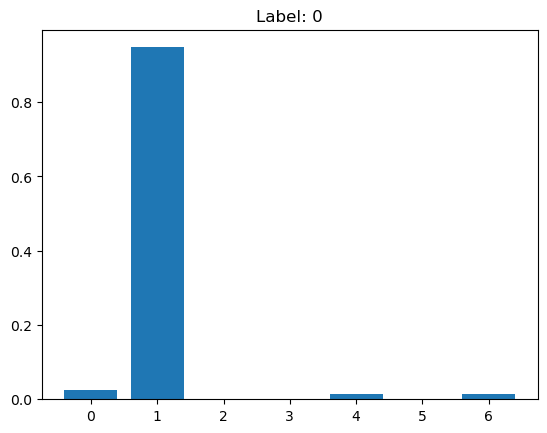

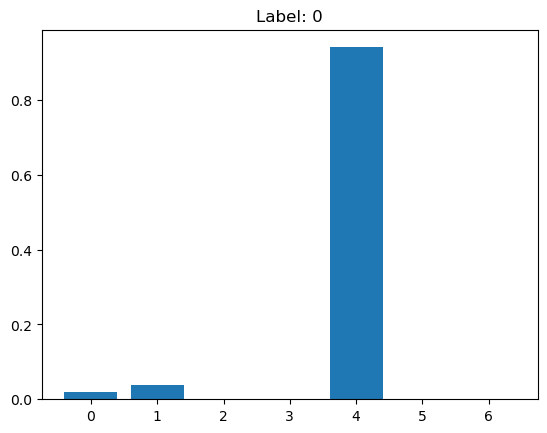

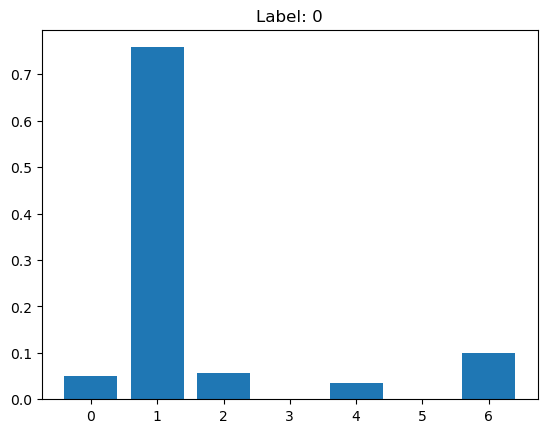

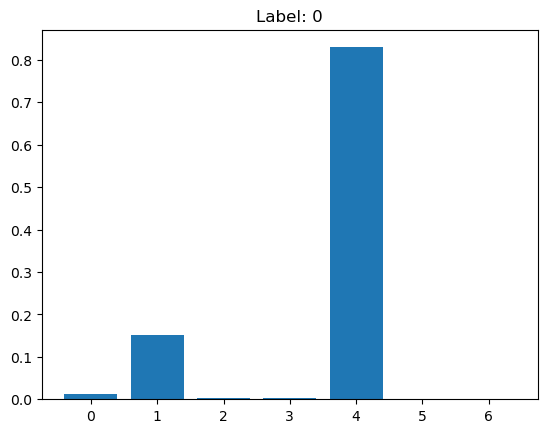

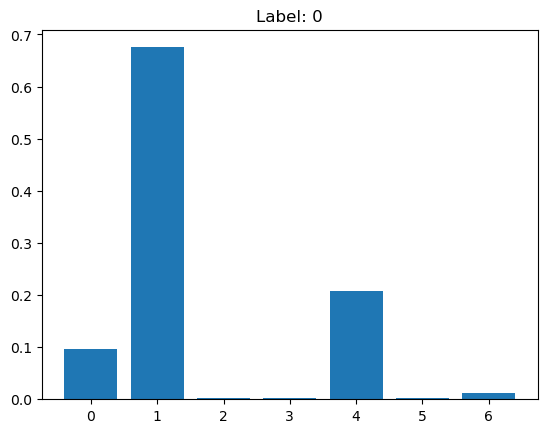

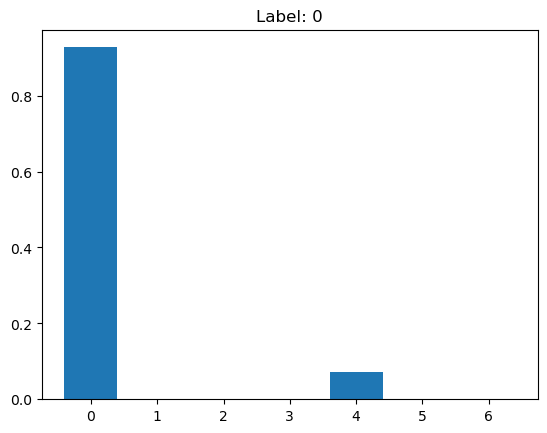

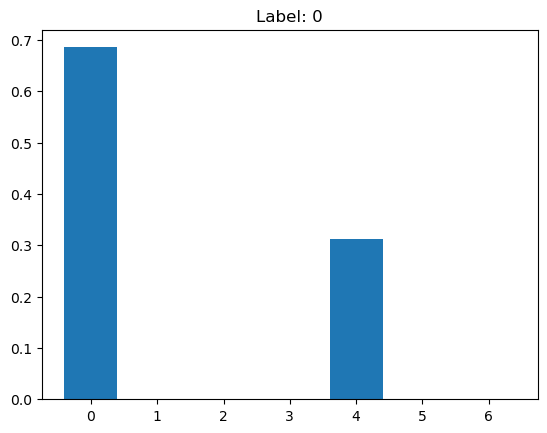

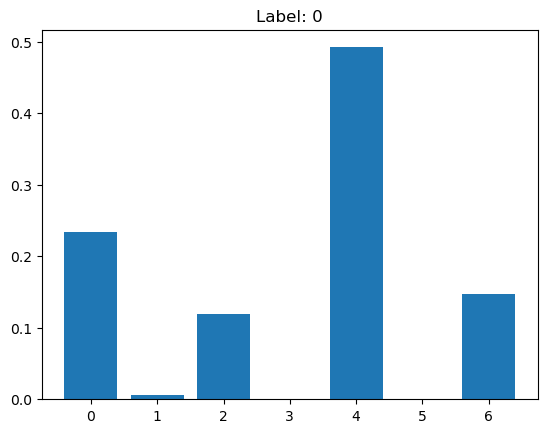

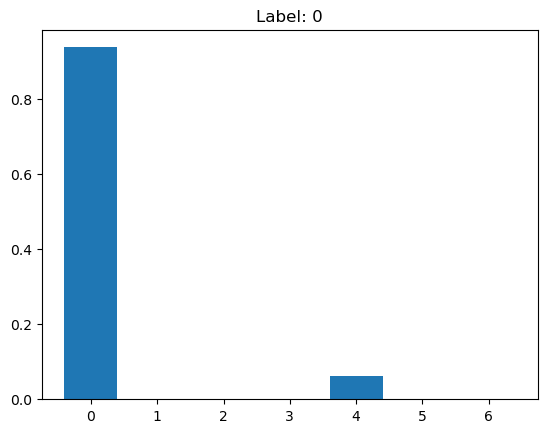

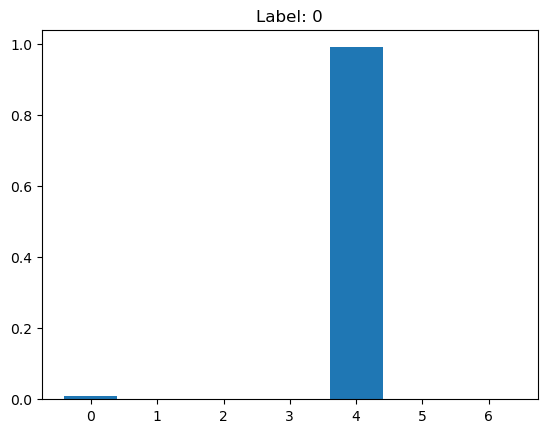

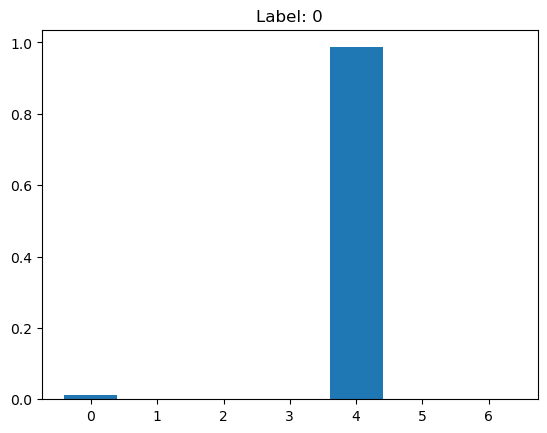

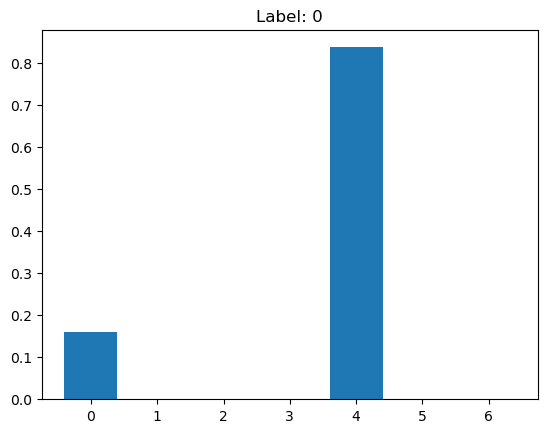

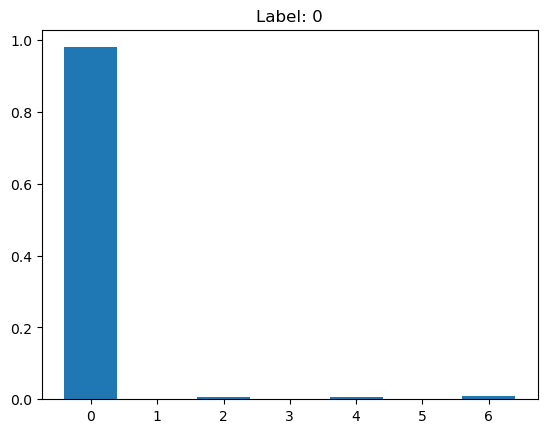

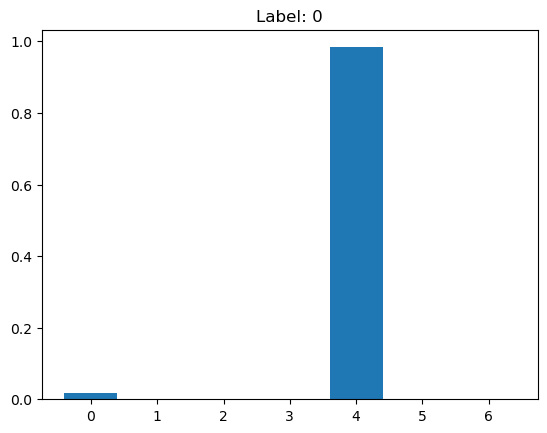

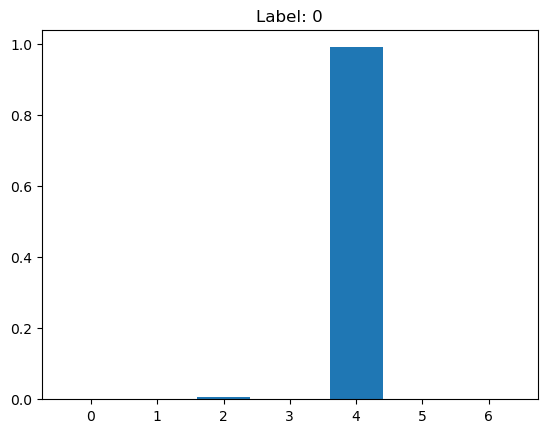

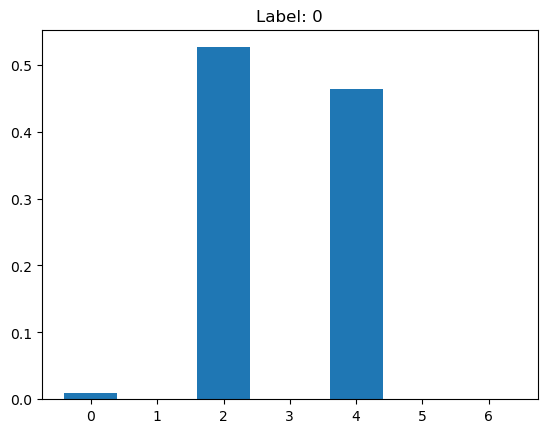

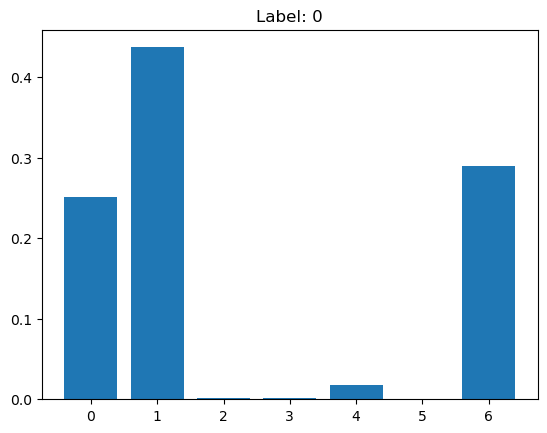

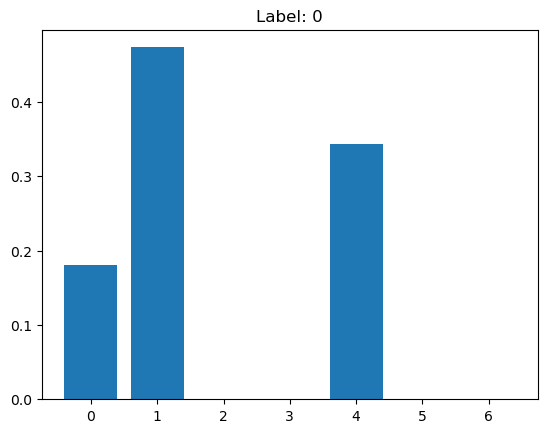

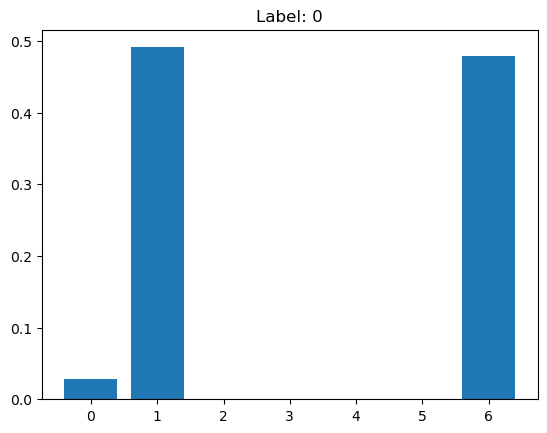

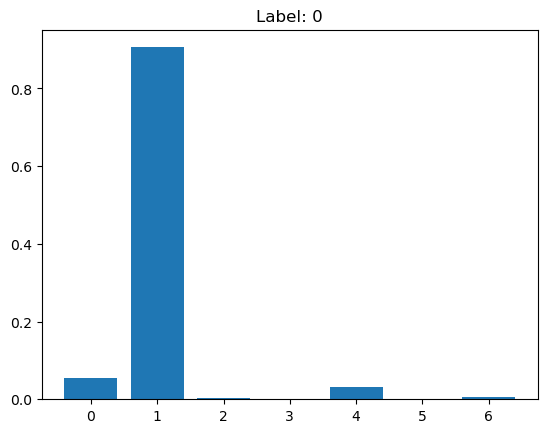

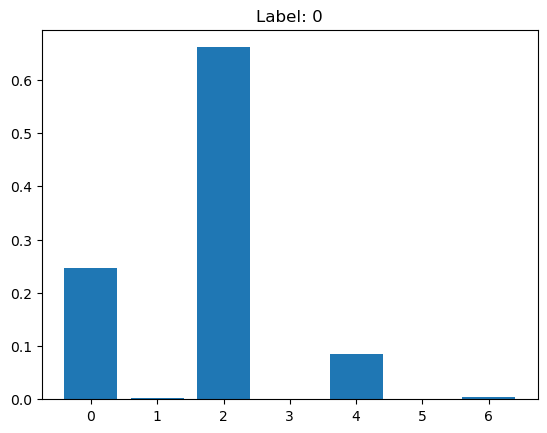

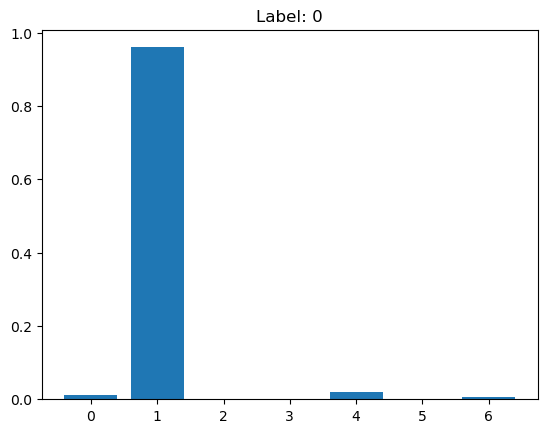

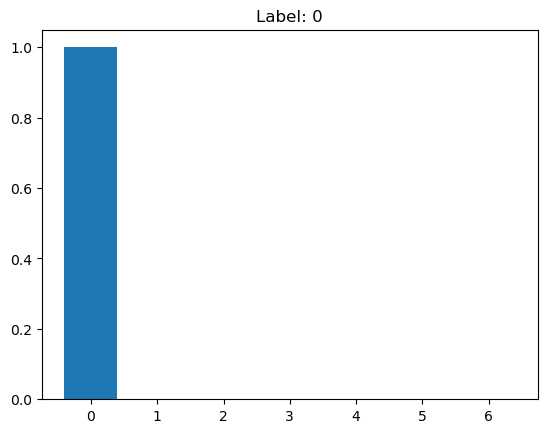

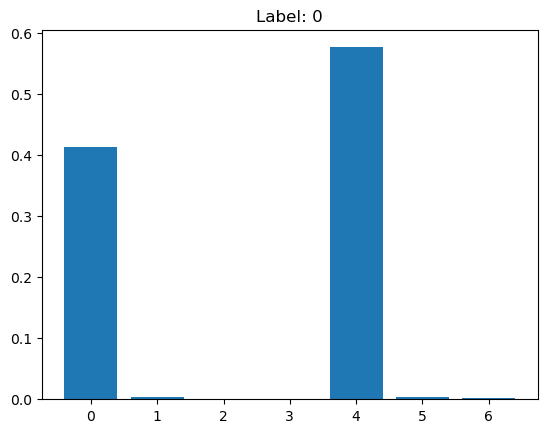

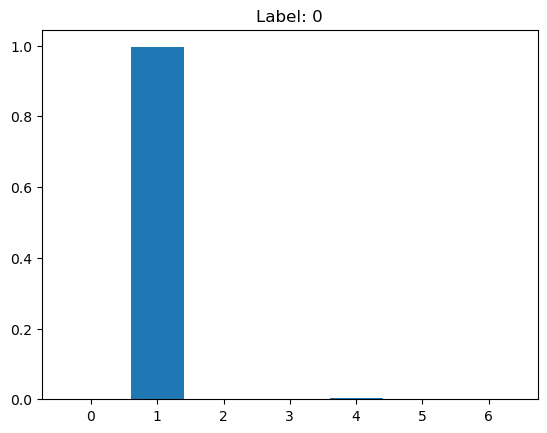

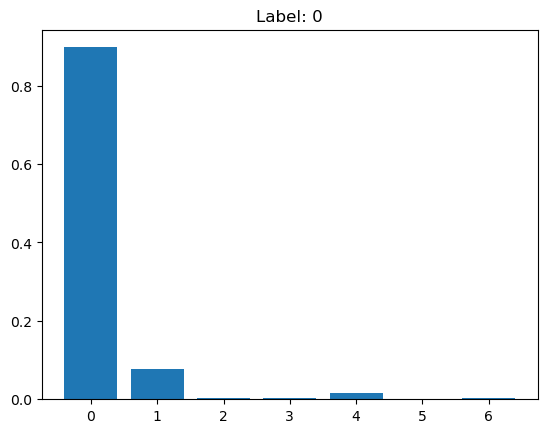

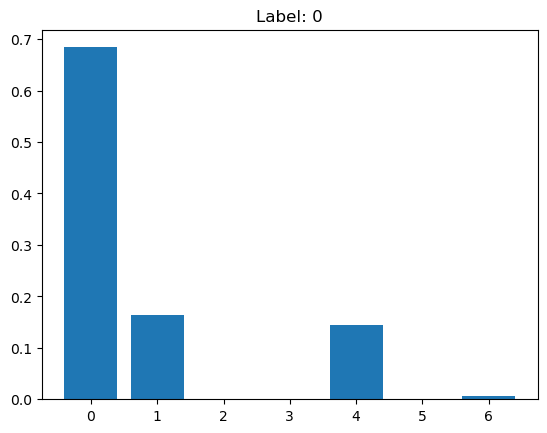

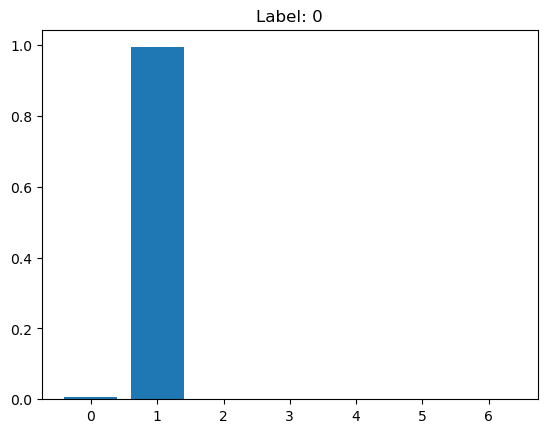

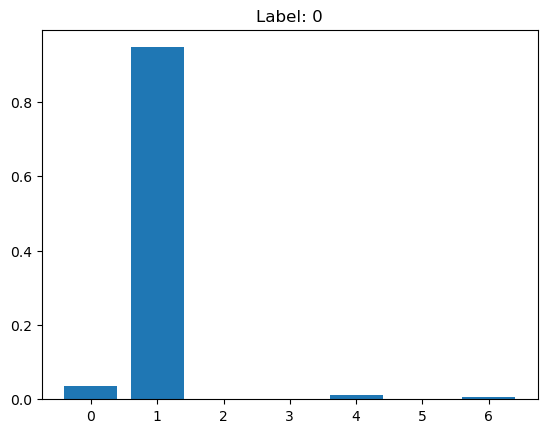

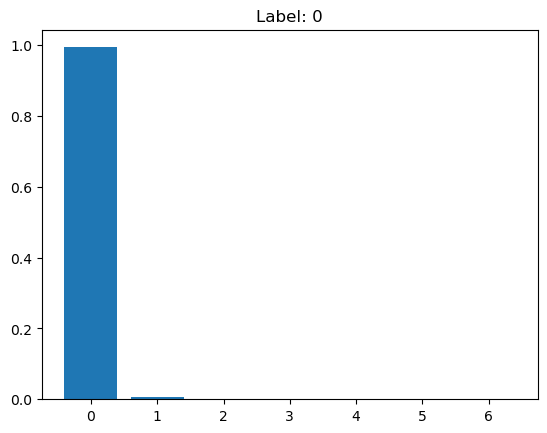

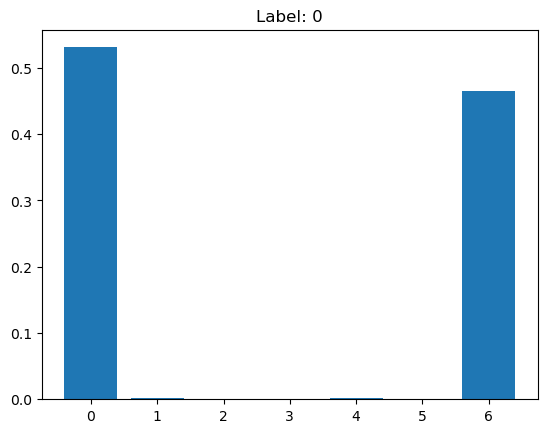

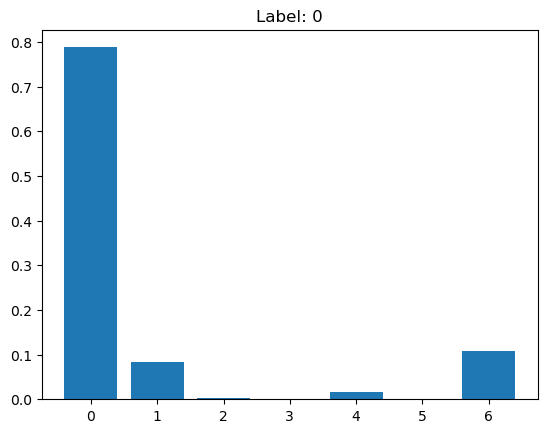

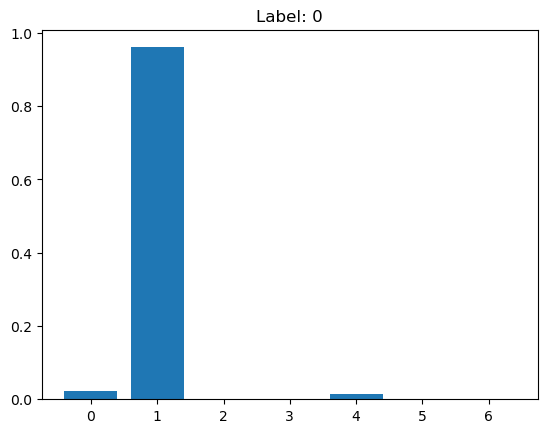

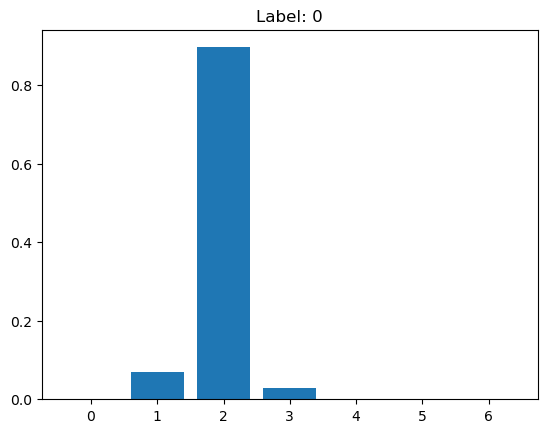

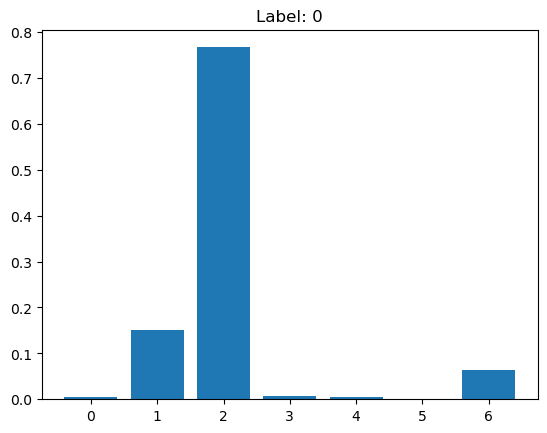

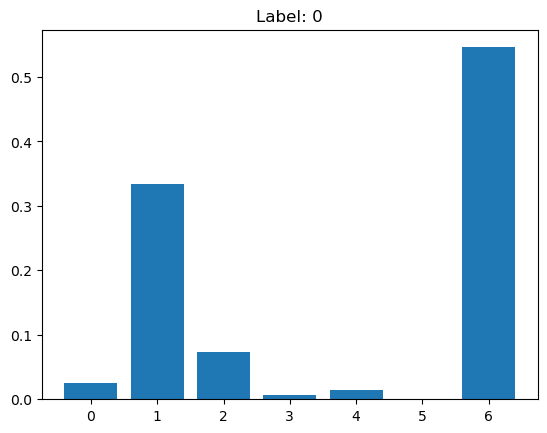

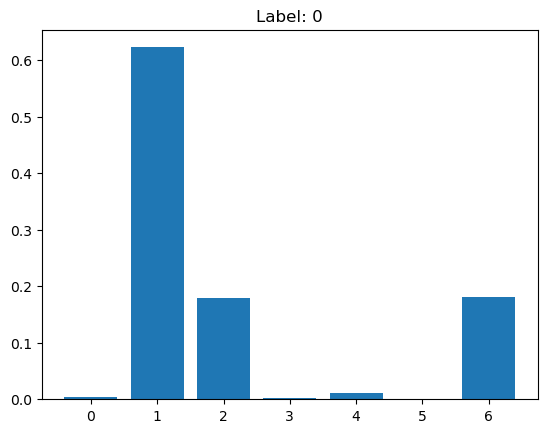

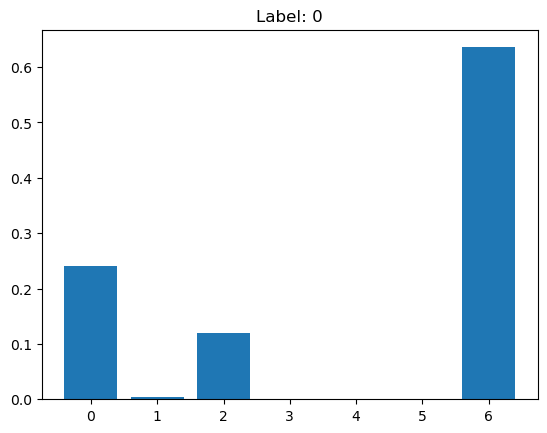

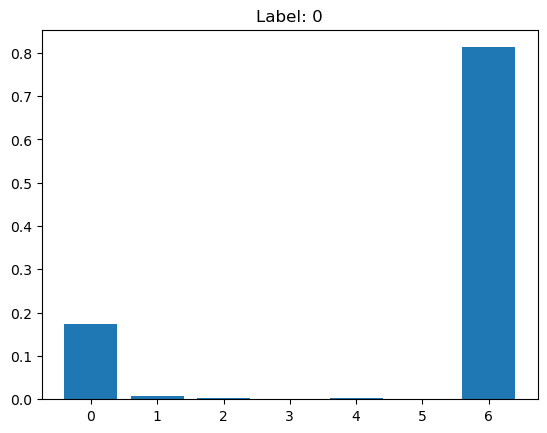

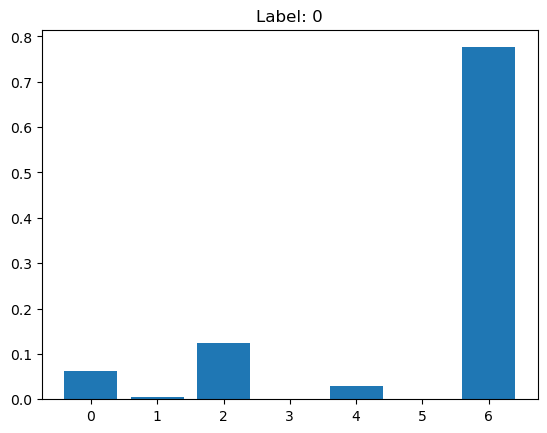

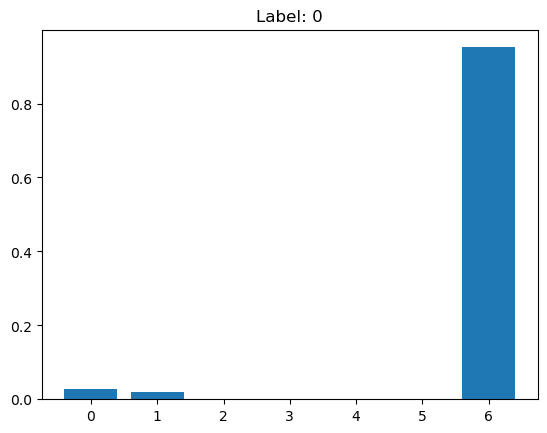

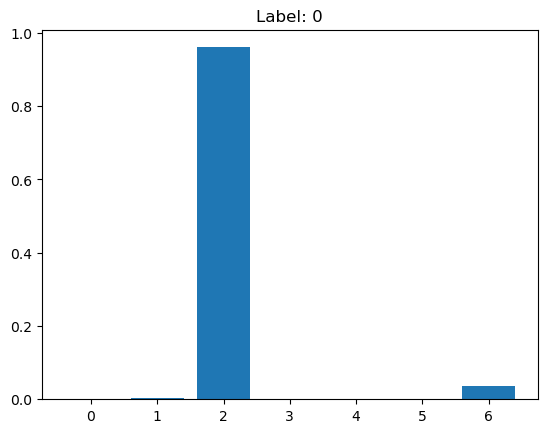

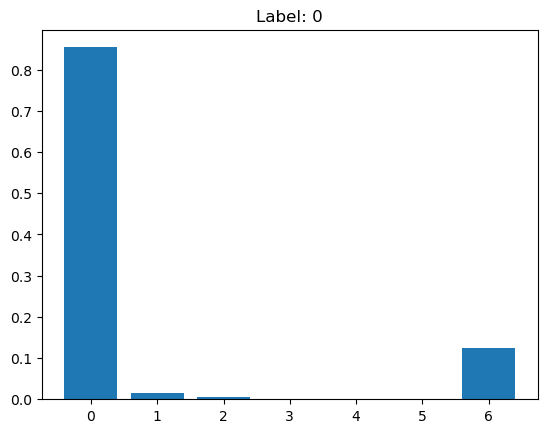

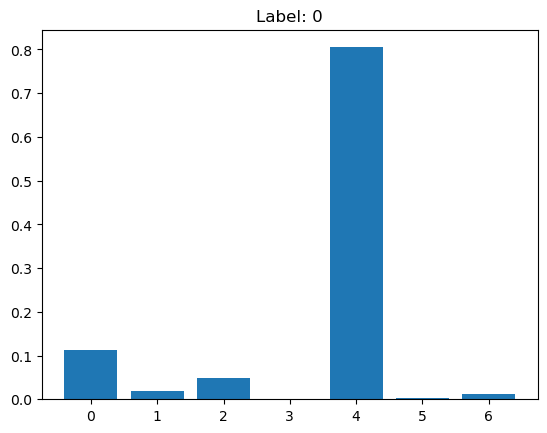

In [98]:
for i in range(soft_preds.shape[0]):
    plt.bar(np.arange(7), soft_preds[i])
    plt.title(f'Label: {labels[i]}')
    plt.show();